In [2]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

import matplotlib.pyplot as plt
import pandas as pd
import torch

import numpy as np
import matplotlib.pyplot as plt
import os


/home/user-prog/.local/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
dirname = os.path.join(os.path.abspath(os.curdir), 'data', 'underwork')

raw_data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}
for v in raw_data:
    tsdf_c = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    tsdf_w = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    raw_data[v] = (tsdf_c, tsdf_w, tsdf_m)

In [4]:
data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}

for v in raw_data:
    calm = raw_data[v][0]
    work = raw_data[v][1]
    sex = raw_data[v][2].iloc[0]["values"]
    weight = raw_data[v][2].iloc[1]["values"]
    height = raw_data[v][2].iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    data[v] = (calm, work)

In [5]:
validation = {"25":(), "27":()}
for v in validation:
    calm = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    work = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    sex = tsdf_m.iloc[0]["values"]
    weight = tsdf_m.iloc[1]["values"]
    height = tsdf_m.iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    validation[v] = (calm, work)

In [6]:
ts = pd.DataFrame()

for v in data:
   calm = data[v][0]
   work = data[v][1]
   ts = pd.concat([ts, calm, work], sort=False, axis=0)

In [7]:
ts.index = np.arange(len(ts.index))
ts.index = pd.to_datetime(ts.index)
sec = 1000000000
delta = pd.to_datetime(2 * sec) - pd.to_datetime(sec)
times = [pd.to_datetime(sec)]
for i in range(1, len(ts.index)):
    times += [times[i - 1] + delta]
ts.index = times

In [9]:
pdts_data = PandasDataset(ts, freq='S', target='1')
test_size = 7000
train,test = split(pdts_data, offset=-test_size)

In [10]:
EPOCHS = 5
model = DeepAREstimator(freq='S', prediction_length=test_size, trainer_kwargs={'max_epochs':EPOCHS})

In [12]:
predictor = model.train(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/user-prog/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                           | Out sizes     
----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | [[1, 1], [1, 1], [1, 7181, 7], [1, 7181], [1, 7181], [1, 7000, 7]] | [1, 100, 7000]
----------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)


Epoch 0: |          | 50/? [05:50<00:00,  0.14it/s, v_num=1, train_loss=0.892]

Epoch 0, global step 50: 'train_loss' reached 0.89244 (best 0.89244), saving model to '/home/user-prog/Desktop/timeseries/TimeSeries/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [06:04<00:00,  0.14it/s, v_num=1, train_loss=-.760]

Epoch 1, global step 100: 'train_loss' reached -0.76033 (best -0.76033), saving model to '/home/user-prog/Desktop/timeseries/TimeSeries/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [08:25<00:00,  0.10it/s, v_num=1, train_loss=-1.14]

Epoch 2, global step 150: 'train_loss' reached -1.13685 (best -1.13685), saving model to '/home/user-prog/Desktop/timeseries/TimeSeries/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [10:05<00:00,  0.08it/s, v_num=1, train_loss=-1.21]

Epoch 3, global step 200: 'train_loss' reached -1.20586 (best -1.20586), saving model to '/home/user-prog/Desktop/timeseries/TimeSeries/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [06:28<00:00,  0.13it/s, v_num=1, train_loss=-1.31]

Epoch 4, global step 250: 'train_loss' reached -1.30702 (best -1.30702), saving model to '/home/user-prog/Desktop/timeseries/TimeSeries/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 50/? [06:28<00:00,  0.13it/s, v_num=1, train_loss=-1.31]


In [13]:
test = test.generate_instances(prediction_length = test_size, windows=1)
forecast = list(predictor.predict(test.input))

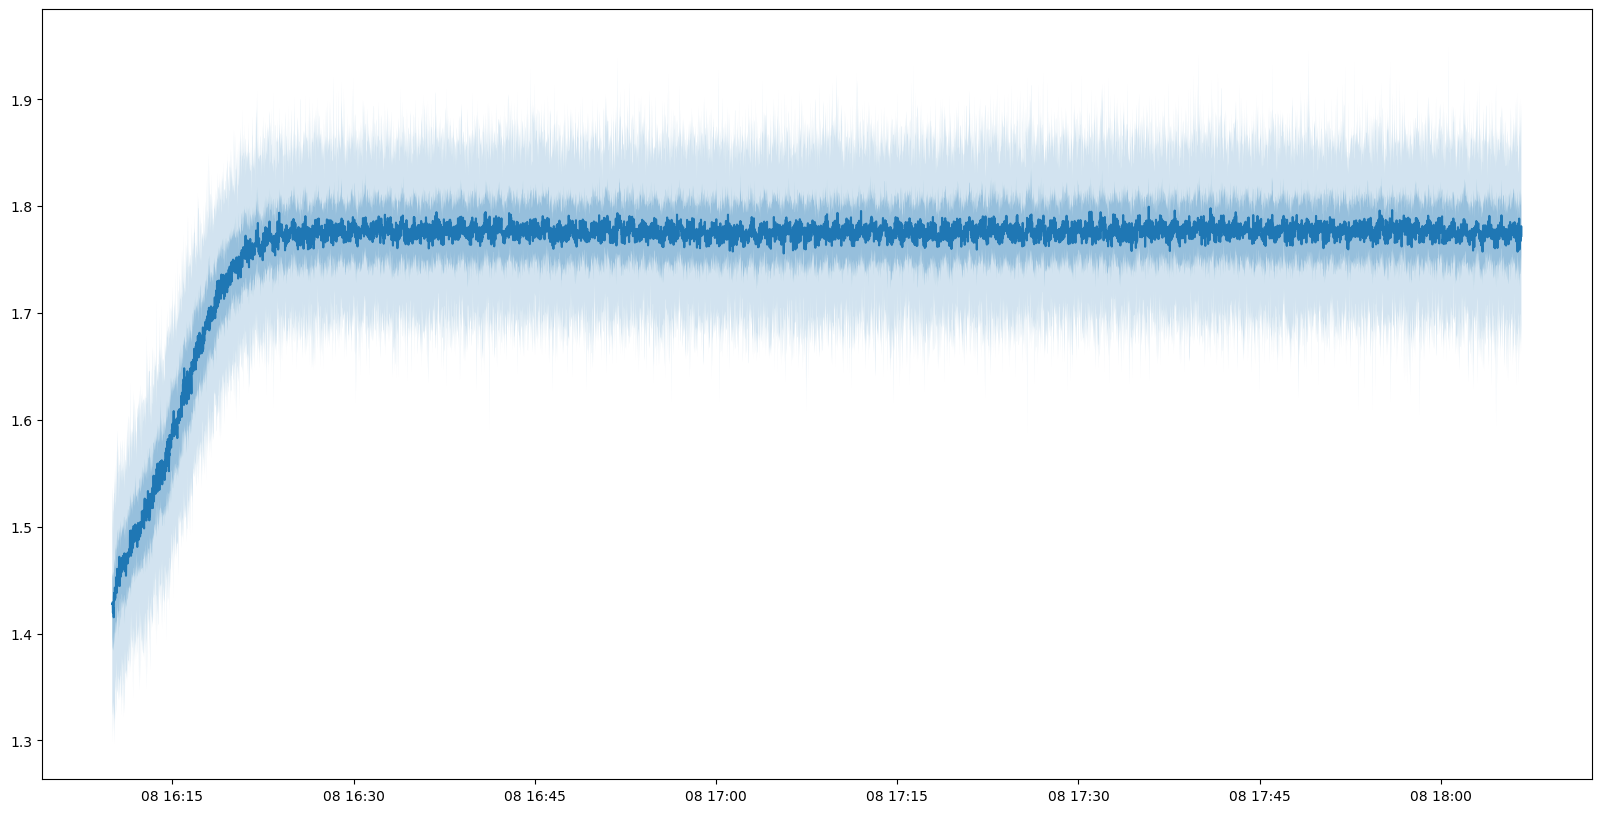

In [20]:
plt.figure(figsize=(20,10))
for fore in forecast:
    fore.plot()